##1.1. Giải nén dữ liệu
1. (thủ công) Download dữ liệu từ nền tảng Kaggle:
https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset/
2. (thủ công) Upload lại lển Drive cá nhân
3. Copy từ Drive vào Colab
4. Giải nén

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cp -fv /content/drive/MyDrive/Datasets/FaceMaskDataset.zip /content/FaceMaskDataset.zip
drive.flush_and_unmount()

!rm -rf /content/Face\ Mask\ Dataset
!rm -rf /content/dataset

!unzip -q /content/FaceMaskDataset.zip -d /content
!mv /content/Face\ Mask\ Dataset /content/dataset

Mounted at /content/drive
'/content/drive/MyDrive/Datasets/FaceMaskDataset.zip' -> '/content/FaceMaskDataset.zip'


1.2. Cài đặt các thư viện cần thiết

In [2]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from datetime import datetime

from sklearn.metrics import classification_report
from google.colab.patches import cv2_imshow
from IPython.display import HTML

!pip install git+https://github.com/hukkelas/DSFD-Pytorch-Inference.git
import face_detection

  Cloning https://github.com/hukkelas/DSFD-Pytorch-Inference.git to /tmp/pip-req-build-aj55q2zj
  Running command git clone -q https://github.com/hukkelas/DSFD-Pytorch-Inference.git /tmp/pip-req-build-aj55q2zj
  Created wheel for face-detection: filename=face_detection-0.2.1-py3-none-any.whl size=29730 sha256=ef9aeab8dd7543561256acedf0c00cc98bece3a7f39e973c3c02e67ca2786526
  Stored in directory: /tmp/pip-ephem-wheel-cache-uqd97rsl/wheels/11/5d/8c/04ffb7a0ca5427f3e674703ea75ecb16542e94efcc46d6bc1b
Successfully built face-detection


1.3. Hiển thị thông tin về bộ dữ liệu

In [3]:
for _name in ("Train", "Validation", "Test"):
  _total_count = len(glob(f'/content/dataset/{_name}/*/*'))
  _neg_count = len(glob(f'/content/dataset/{_name}/WithMask/*'))
  _pos_count = len(glob(f'/content/dataset/{_name}/WithoutMask/*'))
  print(f"{_name}: {_total_count} ({_neg_count} : {_pos_count})")

Train: 10000 (5000 : 5000)
Validation: 800 (400 : 400)
Test: 992 (483 : 509)


## Biểu đồ hiển thị bộ dữ liệu

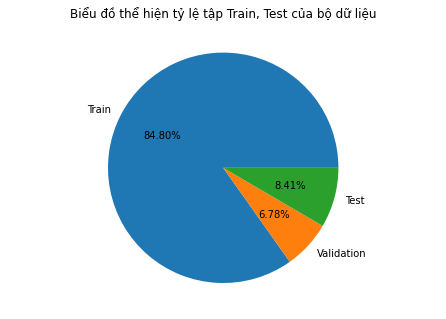

In [4]:
from matplotlib import pyplot as plt 
import numpy as np 
fig = plt.figure() 
ax = fig.add_axes([0,0,1,1]) 
ax.axis('equal') 
Data = ['Train',"Validation", 'Test'] 
image = [10000,800,992] 
ax.pie(image, labels = Data,autopct='%1.2f%%')
plt.title('Biểu đồ thể hiện tỷ lệ tập Train, Test của bộ dữ liệu')
plt.show()

#### Biểu đồ thể hiện bộ dữ liệu trong tập Train





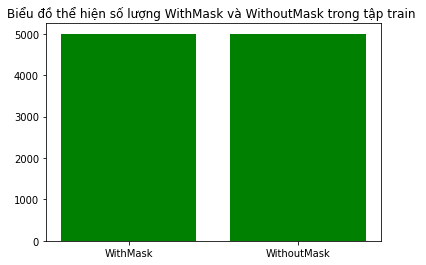

In [5]:
mask =['WithMask','WithoutMask']
image1 = [5000,5000]
plt.bar(mask,image1,color = 'green') 
plt.title('Biểu đồ thể hiện số lượng WithMask và WithoutMask trong tập train ')
plt.show()

#### Biểu đồ thể hiện bộ dữ liệu trong tập Test

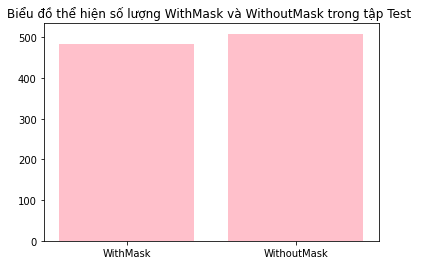

In [6]:
mask =['WithMask','WithoutMask']
image1 = [483,509]
plt.bar(mask,image1,color = 'pink') 
plt.title('Biểu đồ thể hiện số lượng WithMask và WithoutMask trong tập Test ')
plt.show()

#### Biểu đồ hiển thị dữ liệu tập Validation

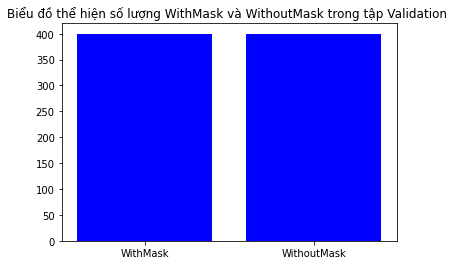

In [7]:
mask =['WithMask','WithoutMask']
image2 = [400,400]
plt.bar(mask,image2,color = 'blue') 
plt.title('Biểu đồ thể hiện số lượng WithMask và WithoutMask trong tập Validation ')
plt.show()

##1.4. Thiết lập các biến constant

In [8]:
model_path = '/content/mask_classification_model.h5'

batch_size = 128

step_per_epoch = int(np.ceil(len(glob('/content/dataset/Train/*/*')) // batch_size))
validation_steps = int(np.ceil(len(glob('/content/dataset/Validation/*/*')) // batch_size))

image_h, image_w = 128, 128
num_classes = 2
classes = ['WithMask','WithoutMask']

##1.5. Đọc các ảnh từ bộ dữ liệu
- Resize ảnh theo độ phân giải 128x 128, và scale các tensor về khoảng [-1, 1].
- Đọc 3 bộ riêng biệt: Train, Validation và Test.

In [9]:
label_map = {v:i for i, v in enumerate(classes)}

def read_img(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img, channels=3)
  img.set_shape([None, None, 3])
  img = tf.image.resize(img, [image_w, image_h])
  img  = img/127.5 - 1
  return img

def load_data(image_path, label):
  image = read_img(image_path)
  return image, label

def get_images_and_labels(folder_name):
  images = glob(f'/content/dataset/{folder_name}/*/*')
  np.random.shuffle(images)
  labels = [label_map[x.split('/')[-2]] for x in images]
  return images, labels

def data_generator(features, labels):
  dataset = tf.data.Dataset.from_tensor_slices((features, labels))
  dataset = dataset.shuffle(buffer_size=100)
  autotune = tf.data.experimental.AUTOTUNE
  dataset = dataset.map(load_data, num_parallel_calls=autotune)
  dataset = dataset.batch(batch_size=batch_size)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(autotune)
  return dataset

trn_images, trn_labels = get_images_and_labels('Train')
trn_dataset = data_generator(trn_images, trn_labels)

val_images, val_labels = get_images_and_labels('Validation')
val_dataset = data_generator(val_images, val_labels)

tst_images, tst_labels = get_images_and_labels('Test')
tst_dataset=data_generator(tst_images, tst_labels)

##1.6. Hiển thị một số ảnh minh họa

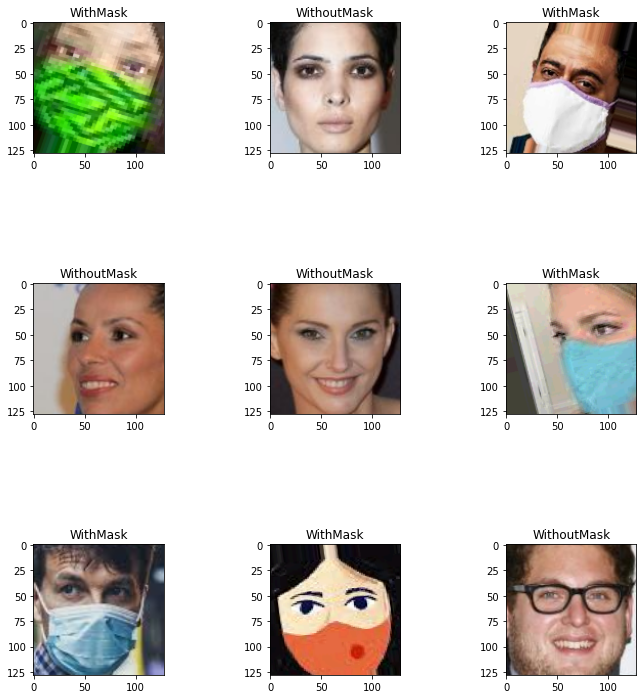

In [10]:

def show_img(dataset):
  plt.figure(figsize=(12, 12))
  for i in range(9):
    for val in dataset.take(1):
      img  = (val[0][i] + 1)*127.5
      plt.subplot(3, 3, i + 1)
      plt.imshow(tf.cast(img, tf.uint8))
      plt.title(classes[val[1][i].numpy()])
      plt.subplots_adjust(hspace=1)
  plt.show()

show_img(trn_dataset)

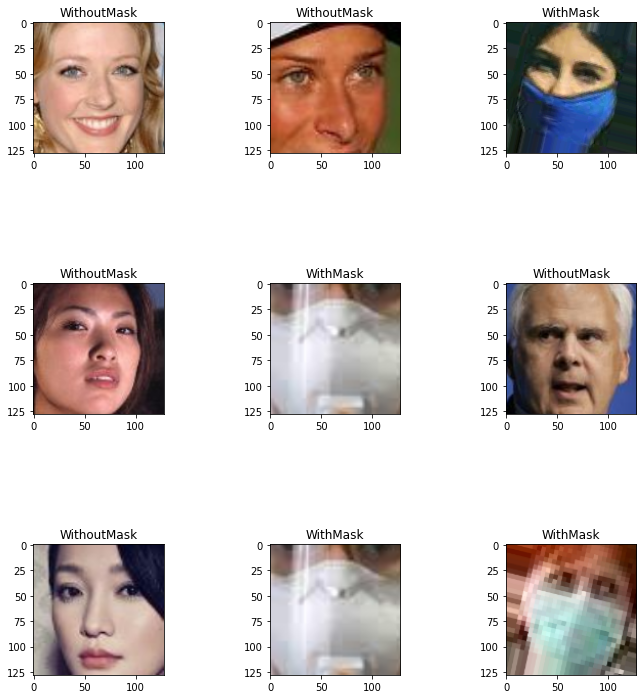

In [11]:
show_img(tst_dataset)

###2. Xây dựng mô hình

### 2.1 Bài toán 1 sử dụng mô hình rentinaface 

In [12]:
image_max_res = 1024

def resize_image(img):
  height, width = img.shape[:2]
  if height > image_max_res or width > image_max_res:
    scaling_factor = min(image_max_res/height, image_max_res/width)
    img = cv2.resize(img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)
  return img

print(face_detection.available_detectors)

face_detector = face_detection.build_detector(
  "RetinaNetResNet50", 
  max_resolution=image_max_res)

['DSFDDetector', 'RetinaNetResNet50', 'RetinaNetMobileNetV1']


Downloading: "https://folk.ntnu.no/haakohu/RetinaFace_ResNet50.pth" to /root/.cache/torch/hub/checkpoints/RetinaFace_ResNet50.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

##2.2. Xây dựng bài toán 2: Face Mask Classification
Sử dụng phương pháp Transfer Learning với mô hình Xception (đã huấn luyện trên ImageNet).

In [13]:
base_model = tf.keras.applications.Xception(include_top=False,
                                       input_shape=(None, None, 3),
                                       weights='imagenet')
base_model.trainable = False
layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
layer = tf.keras.layers.Dense(102, activation='relu')(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(layer)
model = tf.keras.models.Model(base_model.inputs,output)
model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                      

import GPU

In [14]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [15]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')
def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)
def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()
# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
6.568739406999953
GPU (s):
0.11705997299998216
GPU speedup over CPU: 56x


2.2.1. Thiết lập các tham số và huấn luyện mô hình

In [ ]:
epochs = 10

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        model_path, 
        save_best_only=True,
        monitor='loss')
]
history = model.fit(trn_dataset,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=step_per_epoch,
          validation_data=val_dataset,
          validation_steps=validation_steps,
          validation_batch_size=batch_size,
          callbacks=callbacks)




Epoch 1/10
78/78 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9814

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


78/78 [==============================] - 38s 414ms/step - loss: 0.0490 - accuracy: 0.9814 - val_loss: 0.0187 - val_accuracy: 0.9961
Epoch 2/10
78/78 [==============================] - 31s 401ms/step - loss: 0.0180 - accuracy: 0.9951 - val_loss: 0.0193 - val_accuracy: 0.9961
Epoch 3/10
78/78 [==============================] - 31s 397ms/step - loss: 0.0102 - accuracy: 0.9972 - val_loss: 0.0133 - val_accuracy: 0.9987
Epoch 4/10
78/78 [==============================] - 31s 395ms/step - loss: 0.0084 - accuracy: 0.9978 - val_loss: 0.0164 - val_accuracy: 0.9974
Epoch 5/10
78/78 [==============================] - 31s 396ms/step - loss: 0.0064 - accuracy: 0.9981 - val_loss: 0.0126 - val_accuracy: 0.9987
Epoch 6/10
78/78 [==============================] - 31s 396ms/step - loss: 0.0036 - accuracy: 0.9995 - val_loss: 0.0127 - val_accuracy: 0.9987
Epoch 7/10
78/78 [==============================] - 31s 396ms/step - loss: 0.0030 - accuracy: 0.9991 - val_loss: 0.0136 - val_accuracy: 0.9987
Epoch 8/10

In [ ]:
#Lưu model
file_model = "/content/drive/MyDrive/Datasets/mask_classification_model.h5"
model.save(file_model)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Biểu độ chính xác của mô hình
### Trên tập Train


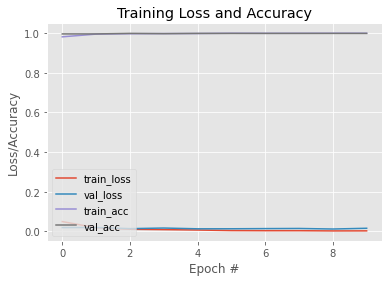

In [ ]:
# plot the training loss and accuracy
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("/content/drive/MyDrive/Datasets")

In [18]:
from google.colab import drive
drive.mount("/content/driver")

Drive already mounted at /content/driver; to attempt to forcibly remount, call drive.mount("/content/driver", force_remount=True).


In [20]:
from keras.models import load_model
model = load_model("/content/driver/MyDrive/Datasets/mask_classification_model.h5")

2.2.2. Hiển thị một số  dự đoán kết quả ngẫu nhiên

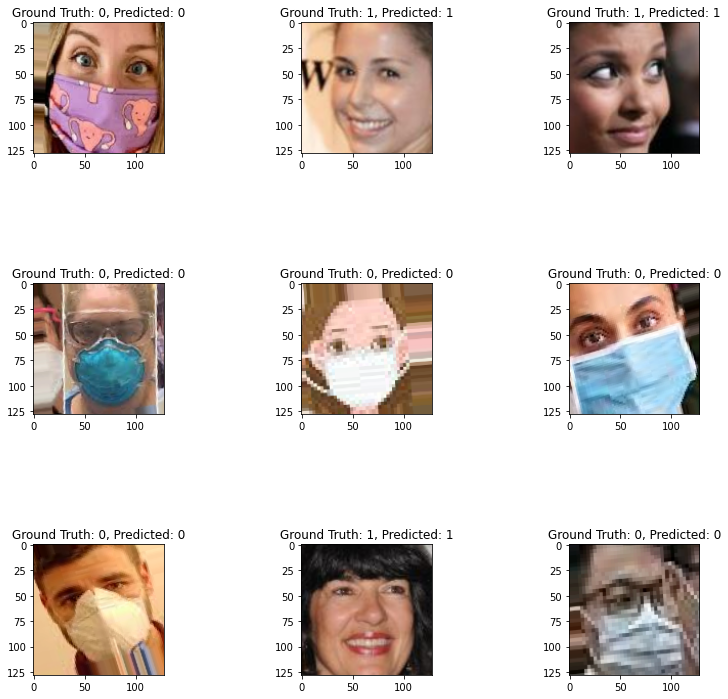

In [21]:
plt.figure(figsize=(12, 12))
for i in range(9):
  for val in trn_dataset.take(1):
    plt.subplot(3, 3, i + 1)
    img  = (val[0][i] + 1)*127.5
    plt.imshow(tf.cast(img, tf.uint8))
    y_pred = model.predict(np.expand_dims(val[0][i], axis=0))
    y_pred = np.argmax(y_pred, axis=1)
    plt.title('Ground Truth: {}, Predicted: {}'.format(val[1][i], y_pred[0]))
    plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

2.2.3. Đánh giá mô hình trên tập Test

In [ ]:
prd_labels = []
for image_path in (tst_images):
  image = read_img(image_path)
  y_pred = model.predict(np.expand_dims(image,axis=0))
  y_pred = np.argmax(y_pred,axis=1)
  prd_labels.append(y_pred)

print(classification_report(tst_labels, prd_labels))

2.3. Thử nghiệm mô hình

2.3.1 load hình ảnh


In [ ]:
!rm -rf /content/assets
!mkdir /content/assets

!wget -q -O /content/assets/image1.jpg https://unsplash.com/photos/1d_nqtAnpLM/download?force=true&w=1920
!wget -q -O /content/assets/image2.jpg https://unsplash.com/photos/XdWkFaHI97c/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjM4MDg0MTQ0&force=true&w=1920
!wget -q -O /content/assets/image3.jpg https://unsplash.com/photos/Gq9L5zS1uQ8/download?force=true&w=1920
!wget -q -O /content/assets/image4.jpg https://unsplash.com/photos/uN8TV9Pw2ik/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjM4MDg0OTg1&force=true&w=1920

2.3.2. Các hàm hiển thị

In [ ]:
color_box_map = {
  0: [0, 1, 0],
  1: [1, 0, 0]
}

model = tf.keras.models.load_model(model_path)

def visualize_detections(image, boxes):
  figsize = (12, 12)
  linewidth = 1
  
  image = np.array(image, dtype=np.uint8)
  plt.figure(figsize=figsize)
  plt.axis('off')
  plt.imshow(image)
  ax = plt.gca()

  for box in boxes:
    left, bottom, right, top = box
    bottom = int(np.round(bottom))
    top = int(np.round(top))
    left = int(np.round(left))
    right = int(np.round(right))

    face_image = image[bottom:top, left:right]
    if not face_image.shape[0] or not face_image.shape[1]:
      continue

    face_image = tf.image.resize(face_image, [image_w, image_h])
    face_image = face_image / 127.5 - 1
    label = model.predict(np.expand_dims(face_image, axis=0))
    label = np.argmax(label, axis=1)[0]

    patch = plt.Rectangle(
        (left, bottom), right-left, top-bottom, 
        fill=False,
        edgecolor=color_box_map[label], 
        linewidth=linewidth)
    ax.add_patch(patch)

def visualize_detections_video(image, boxes):
  linewidth = 1

  image = np.array(image, dtype=np.uint8)
  for box in boxes:
    left, bottom, right, top = box
    bottom = int(np.round(bottom))
    top = int(np.round(top))
    left = int(np.round(left))
    right = int(np.round(right))

    face_image = image[bottom:top, left:right]
    if not face_image.shape[0] or not face_image.shape[1]:
      continue

    face_image = tf.image.resize(face_image, [image_w, image_h])
    face_image = face_image / 127.5 - 1
    label = model.predict(np.expand_dims(face_image, axis=0))
    label = np.argmax(label, axis=1)[0]

    cv2.rectangle(image, (left, bottom), (right, top), color_map_video[label], linewidth)
  return image

2.3.3. Thử nghiệm với hình ảnh đã tải

/content/assets/image2.jpg: 0:00:05.662434
/content/assets/image1.jpg: 0:00:02.600029
/content/assets/image3.jpg: 0:00:05.396103
/content/assets/image4.jpg: 0:00:03.139450


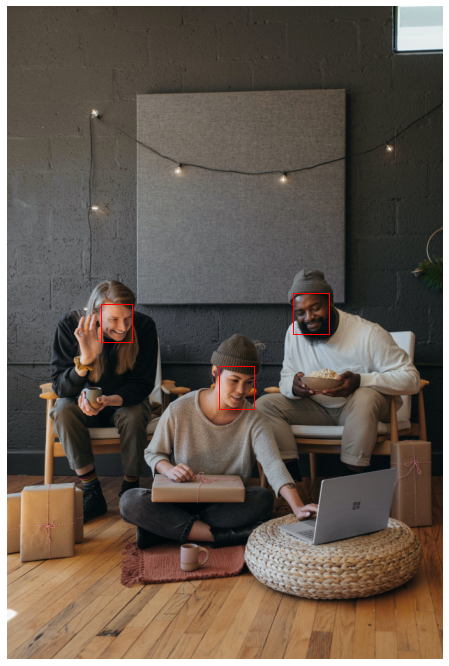

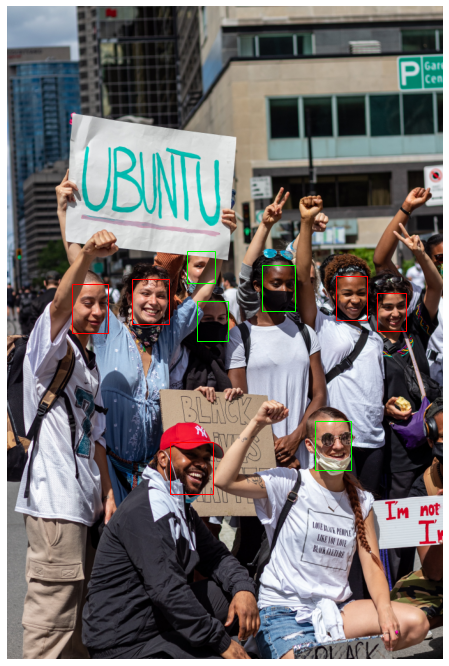

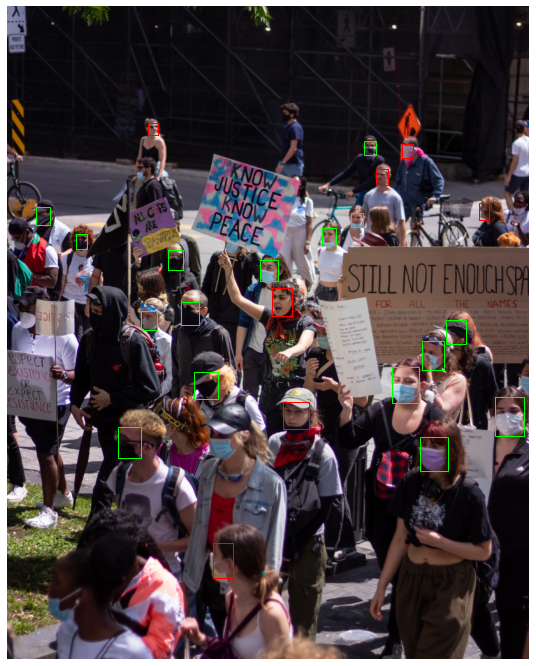

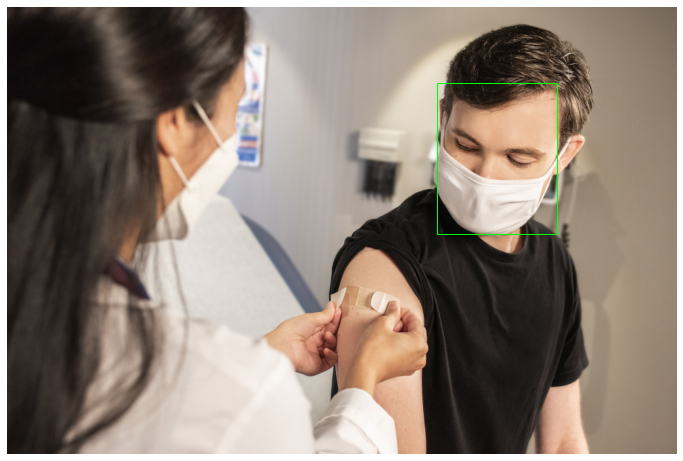

In [ ]:
for image_path in glob('/content/assets/*.jpg'):
  start = datetime.now()
  image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) 
  image = resize_image(image) 
  boxes = face_detector.detect(image[:, :, ::-1])[:, :4]
  labels = visualize_detections(image, boxes)
  end = datetime.now()

  print(f"{image_path}: {end - start}")

2.2.4. Thử nghiệm với ảnh chụp trực tiếp từ Webcam

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true})
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Ảnh Webcam không đeo khẩu trang

<IPython.core.display.Javascript object>

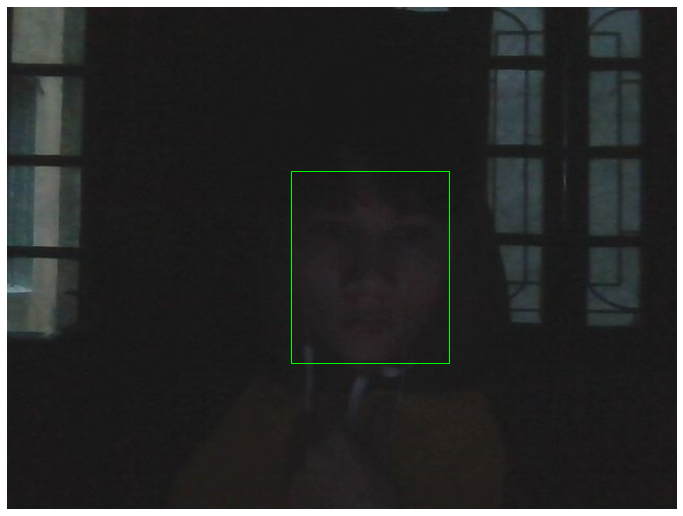

In [ ]:
try:
  image_path = take_photo("selfie_without_facemask.jpg")

  image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) 
  image = resize_image(image) 
  boxes = face_detector.detect(image[:, :, ::-1])[:, :4]
  labels = visualize_detections(image, boxes)

except Exception as err:
  print(str(err))

Ảnh Webcam có đeo khẩu trang

In [ ]:
try:
  image_path = take_photo("selfie_with_facemask.jpg")
  image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) 
  image = resize_image(image) 
  boxes = face_detector.detect(image[:, :, ::-1])[:, :4]
  labels = visualize_detections(image, boxes)
except Exception as err:
  print(str(err))

<IPython.core.display.Javascript object>

name 'visualize_detections' is not defined


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from keras.models import load_model
from keras.preprocessing import image
import datetime
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
from IPython.display import Audio 
import time
def beep():
  display(Audio('/content/driver/MyDrive/Datasets/b.mp3', autoplay=True))
  time.sleep(3)
  # display = nonlocal
   
beep();

In [ ]:
# start streaming video from webcam
from PIL import Image
video_stream( )
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    for (x,y,w,h) in faces:
      face_img = img[y:y + h, x:x + w]
        #  face_image = image[bottom:top, left:right]
      if not face_img.shape[0] or not face_img.shape[1]:
        continue
      face_img = tf.image.resize(face_img,[128,128])
      face_img = face_img / 127.5 - 1
      pred1 = model.predict(np.expand_dims(face_img, axis=0))
      pred = np.argmax(pred1, axis=1)[0]
      score = tf.nn.softmax(pred1[0])
      acc = 100 * np.max(score)     
       
      if pred == 1:
         bbox_array = cv2.rectangle(bbox_array, (x, y), (x + w, y + h), (255, 0, 0), 3)
         bbox_array=cv2.putText(bbox_array,'KHONG KHAU TRANG', ((x + w) // 2, y + h + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (220,20,60),3)
         bbox_array=cv2.putText(bbox_array,"{:.2f}%.".format(acc), ((x + w) // 2, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (220,20,60),2)
         beep()

      else:
        bbox_array = cv2.rectangle(bbox_array, (x, y), (x + w, y + h), (0, 255, 0), 3)
        bbox_array=cv2.putText(bbox_array, 'CO KHAU TRANG', ((x + w) // 2, y + h + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
        bbox_array=cv2.putText(bbox_array,"{:.2f}%.".format(acc), ((x + w) // 2, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (220,20,60),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes
    

<IPython.core.display.Javascript object>